파이썬 머신러닝 완벽가이드 ch4.p. 261~289

# 분류 실습 - 캐글 신용카드 사기 검출

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df= pd.read_csv("/content/drive/MyDrive/데이터/creditcard[1].csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
# 데이터 class 속성 확인
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

매우 불균형한 분포를 가지고 있다.

**지도학습에서 극도로 불균형한 레이블 값 분포로 인한 문제점 해결법**

오버샘플링, 언더샘플링

오버샘플링이 예측성능 상 더 유리한 경우가 많다.

- 언더샘플링 : 많은 데이터 세트를 적은 데이터세트 수준으로 감소시키는 방식. 즉, 정상 레이블을 가진 데이터가 만 건, 이상 레이블을 가진 데이터가 100건이 있다면 정상 레이블 데이터를 100건으로 줄이는 방식

- 오버샘플링 : 이상데이터와 같이 적은 데이터를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법. 동일한 데이터를 단순히 증식하는 방법은 과적합이 되기 때문에 의미가 없으므로 원본 데이터의 피처 값들을 아주 약간만 변경하여 증식시킨다. 대표적으로 SMOTE가 있는데, 이건 적은 데이터 세트에 있는 개별데이터들의 K NN을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어 기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식이다.

In [10]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [7]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

Time 피처는 데이터 생성 관련 작업용 속성으로 큰 의미 없으므로 제거.

Amount는 신용카드 트랙젝션 금액을 의미/

Class는 0일때 정상, 1일때 사기

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

결측치 X, Class만 int형

In [11]:
# 데이터프레임 가공 반환 함수
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df=None):
  df_copy=df.copy()
  df_copy.drop('Time', axis=1, inplace=True)
  return df_copy

In [12]:
# 데이터 가공 후 학습/테스트 데이터 세트를 반환 함수
def get_train_test_dataset(df=None):
  df_copy = get_preprocessed_df(df)
  X_features = df_copy.iloc[:,:-1]
  y_target= df_copy.iloc[:,-1]
  X_train, X_test, y_train, y_test= train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
  return X_train,X_test, y_train, y_test

X_train, X_test, y_train, y_test= get_train_test_dataset(df)

In [11]:
# 비율 확인
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
Class
0    99.827451
1     0.172549
Name: count, dtype: float64
테스트 데이터 레이블 값 비율
Class
0    99.826785
1     0.173215
Name: count, dtype: float64


차이가 적은 것을 알 수 있다.

# 로지스틱 회귀 이용 신용 카드 사기 여부 예측

In [13]:
# 평가지표 출력하는 함수 설정
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)

    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

In [13]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred= lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

In [17]:
get_clf_eval(y_test, lr_pred)

오차행렬:
 [[85283    12]
 [   60    88]]

정확도: 0.9992
정밀도: 0.8800
재현율: 0.5946
F1: 0.7097
AUC: 0.7972


In [14]:
# 모델 학습/예측/평가를 위한 함수
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
  model.fit(ftr_train, tgt_train)
  pred= model.predict(ftr_test)
  pred_proba = model.predict_proba(ftr_test)[:,1]
  get_clf_eval(tgt_test, pred)

# LGBM

In [22]:
from lightgbm import LGBMClassifier
lgbm_clf= LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

# 데이터 분포도 변환 후 모델 학습/예측 평가

In [25]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

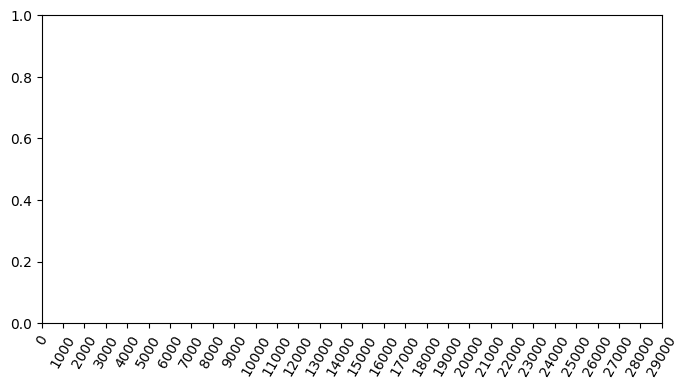

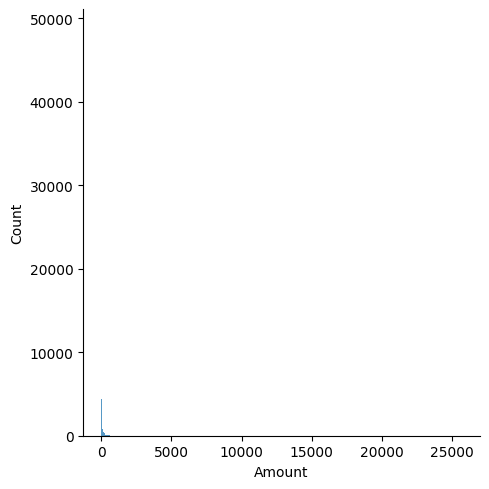

In [23]:
plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=60)
sns.displot(df['Amount'])

In [15]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [28]:
X_train, X_test, y_train, y_test= get_train_test_dataset(df)
print('로지스틱 회귀 예측 성능')
lr_clf=LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train,
                     tgt_test=y_test)

print('LGBM 예측 성능')
lgbm_clf= LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

로지스틱 회귀 예측 성능
오차행렬:
 [[85281    14]
 [   58    90]]

정확도: 0.9992
정밀도: 0.8654
재현율: 0.6081
F1: 0.7143
AUC: 0.8040
LGBM 예측 성능
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.172266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001725 -> initscore=-6.360519
[LightGBM] [Info] Start training from score -6.360519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

성능이 크게 개선되지 않음

In [16]:
# 로그 변환
def get_preprocessed_df(df=None):
  df_copy= df.copy()
  amount_n= np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amiunt_Scaled', amount_n)
  df_copy.drop(['Time','Amount'], axis=1, inplace=True)
  return df_copy

In [30]:
X_train, X_test, y_train, y_test= get_train_test_dataset(df)

print('로지스틱 회귀 예측 성능')
lr_clf=LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train,
                     tgt_test=y_test)

print('LGBM 예측 성능')
lgbm_clf= LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

로지스틱 회귀 예측 성능
오차행렬:
 [[85283    12]
 [   59    89]]

정확도: 0.9992
정밀도: 0.8812
재현율: 0.6014
F1: 0.7149
AUC: 0.8006
LGBM 예측 성능
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001725 -> initscore=-6.360519
[LightGBM] [Info] Start training from score -6.360519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

# 이상치 데이터 제거 후 모델 학습/예측/평가

<Axes: >

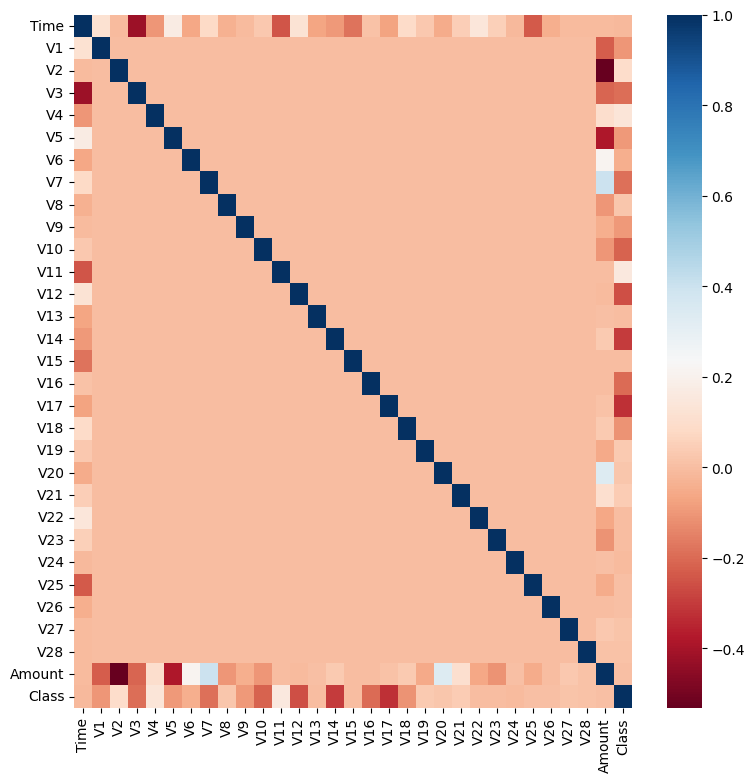

In [31]:
# IQR 사용한 이상치 제거

import seaborn as sns

plt.figure(figsize=(9,9))
corr= df.corr()
sns.heatmap(corr, cmap='RdBu')

양의 상관관계가 높을수록 진한 파란색

In [17]:
# 이상치 찾는 함수
def get_outlier(df=None, column=None, weight=1.5):
  fraud = df[df['Class']==1][column]
  quantile_25= np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75)
  iqr= quantile_75 - quantile_25
  iqr_weight = iqr * weight
  lowest_val = quantile_25 - iqr_weight
  highest_val = quantile_75 + iqr_weight
  outlier_index= fraud[(fraud<lowest_val)|(fraud>highest_val)].index
  return outlier_index

In [18]:
outlier_index= get_outlier(df=df, column='V14', weight=1.5)
print('이상치 인덱스:', outlier_index)

이상치 인덱스: Index([8296, 8615, 9035, 9252], dtype='int64')


In [19]:
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time','Amount'], axis=1, inplace=True)

  outlier_index=get_outlier(df=df_copy, column='V14', weight=1.5)
  df_copy.drop(outlier_index, axis=0, inplace=True)
  return df_copy

In [36]:
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time','Amount'], axis=1, inplace=True)

  outlier_index=get_outlier(df=df_copy, column='V14', weight=1.5)
  df_copy.drop(outlier_index, axis=0, inplace=True)
  return df_copy


X_train, X_test, y_train, y_test= get_train_test_dataset(df)
print('로지스틱 회귀 예측 성능')
lr_clf=LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train,
                     tgt_test=y_test)

print('LGBM 예측 성능')
lgbm_clf= LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

로지스틱 회귀 예측 성능
오차행렬:
 [[85281    14]
 [   48    98]]

정확도: 0.9993
정밀도: 0.8750
재현율: 0.6712
F1: 0.7597
AUC: 0.8355
LGBM 예측 성능
[LightGBM] [Info] Number of positive: 342, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199362, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001715 -> initscore=-6.366350
[LightGBM] [Info] Start training from score -6.366350
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

# SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [20]:
X_train, X_test, y_train, y_test= get_train_test_dataset(df)

In [22]:
from imblearn.over_sampling import SMOTE

smote= SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트:', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트:', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포:\n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트: (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트: (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포:
 Class
0    199020
1    199020
Name: count, dtype: int64


In [24]:
from sklearn.linear_model import LogisticRegression

In [27]:
lr_clf= LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over,
                     tgt_test=y_test)

오차행렬:
 [[82937  2358]
 [   11   135]]

정확도: 0.9723
정밀도: 0.0542
재현율: 0.9247
F1: 0.1023
AUC: 0.9485


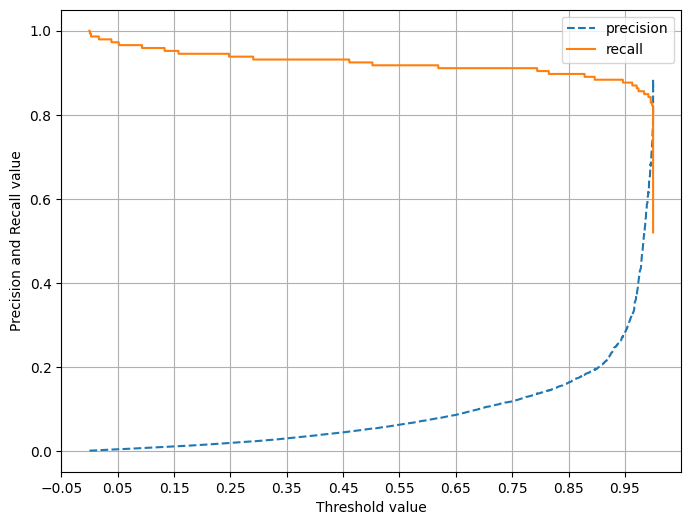

In [29]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    # x축을 threshold 값, y축을 정밀도, 재현율로 그리기
    plt.figure(figsize=(8,6))
    thresholds_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0: thresholds_boundary], linestyle= '--', label='precision')
    plt.plot(thresholds, recalls[0: thresholds_boundary], label='recall')

    # threshold의 값 X축의 scale을 0.1 단위로 변경
    stard, end = plt.xlim()
    plt.xticks(np.round(np.arange(stard, end, 0.1), 2))

    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])


In [33]:
from lightgbm import LGBMClassifier

In [34]:
lgbm_clf= LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                     tgt_train= y_train_over, tgt_test=y_test)

[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.237307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

# 스태킹 앙상블

기존 앙상블과의 차이점으로, 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행한다는 것이다. 즉, 개별 알고리즘의 예측 결과 데이터세트를 최종적인 메타 데이터 세트로 만들어 별도의 ML알고리즘으로 최종학습을 수행하고 테스트 데이터를 기반으로 다시 최종 예측을 수행하는 방식이다

스태킹모델은 두 종류의 모델이 필요한데, 첫번째는 개별적인 기반모델이고 두번째는 이 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어 학습하는 최종 메타모델이다. 스태킹 모델의 핵심은 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합하여 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것이다.

자주 사용되지는 않는다. 많은 개별 모델이 필요하다.

In [36]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data,y_label, test_size=0.2,random_state=0)

In [37]:
#개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100,random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

#스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final = LogisticRegression(C=10)

#개별 모델들을 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train,y_train)
dt_clf.fit(X_train,y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [38]:
#학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test,knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'. format(accuracy_score(y_test,rf_pred)))
print('결정 트리 정확도:{0:.4f}'.format(accuracy_score(y_test,dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test,ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도:0.8947
에이다부스트 정확도: 0.9561


예측 데이터 세트는 1차원이기에, 결과를 행 형태로 붙인 후에 넘파이의 transpose()를 이용해 행과 열의 위치를 바꾼 ndarray로 변환한다

In [39]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

#transpose를 이용해 행과 열의 위치를 교환. 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦.
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [40]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도: 0.9737


-CV 세트 기반의 스태킹

과적합 개선을 위해 최종 메타 모델을 위한 데이터 세트를 만들 때, 교차 검증 기반으로 예측된 결과 데이터 세트를 이용한다.


STEP 1: 각 모델별 원본 학습/데이터를 예측한 결과 값을 기반으로 메타 모델을 위한 학습용/테스트용 데이터 생성

STEP 2: 스텝1의 학습용/테스트용 데이터를 모두 스태킹으로 합쳐 최종 학습용/테스트용 데이터 세트를 생성한다. 메타 모델은 최종적으로 생성된 학습 데이터 세트와 원본 학습 데이터의 레이블을 기반으로 학습하고, 최종적으로 생성된 테스트 데이터 세트 예측후 원본 테스트 데이터의 레이블 데이터를 기반으로 평가함.

In [41]:
#STEP 1 코드로 구현

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
  #지정된 n_folds 값으로 KFold 생성.
  kf = KFold(n_splits=n_folds, shuffle=False)
  #추후에 메타 모델이 학습할 학습 데이터 반환을 위한 넘파이 배열 초기화
  train_fold_pred = np.zeros((X_train_n.shape[0],1))
  test_pred = np.zeros((X_test_n.shape[0],n_folds))
  print(model.__class__.__name__,' model 시작 ')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
    print('\t 폴드 세트: ', folder_counter, ' 시작 ')
    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te = X_train_n[valid_index]

    #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
    model.fit(X_tr, y_tr)
    #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
    train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
    #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
    test_pred[:, folder_counter] = model.predict(X_test_n)

  #폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
  test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

  #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
  return train_fold_pred, test_pred_mean

In [42]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


In [43]:
#STEP 2 코드로 구현
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test,rf_test,dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:', X_train.shape, '원본 테스트 피처 Shape:', X_test.shape)
print('스태킹 학습 피처 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:', Stack_final_X_test.shape)


원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [44]:
#최종 메타 모델인 로지스틱 회귀로 학습 후, 원본 테스트
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

**정리**

대부분의 앙상블은 결정트리 기반의 다수의 약한 학습기를 결합해 변동성을 줄여 예측 오류를 줄이고 성능을 개선한다. 결정트리 알고리즘은 정보의 균일도에 기반해 규칙 트리를 만들어 예측을 수행한다. 직관적이다.

앙상블은 배깅과 부스팅으로 구분된다.
배깅은 학습 데이터를 부트스트래핑해 이를 다수의 약한 학습기가 학습한 후 최종 결과를 결합해 예측하는 방식으로, 랜덤포레스트가 대표적이다.

현대의 앙상블은 부스팅이 더 주류로, 부스팅은 학습기들이 순차적으로 학습을 진행하며 예측이 틀린 데이터에 대해 가중치를 부여하며 다음번 학습기가 학습 할 때 더 높은 정확도를 가질 수 있도록한다.

GBM은 높은 성능을 가지지만, 수행시간이 너무 오래걸린다.

XGBoost와 LGBM은 가장 각광받는 부스팅 기반 머신러닝 패키지이다.

스태킹은 메타 모델이 사용할 학습 데이터 세트와 예측 데이터 세트를 개별 모델의 예측 값들을 스태킹 형태로 결합해 생성하는 데에 있다.